In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [3]:
train_df.shape, test_df.shape

((26370, 41), (6593, 40))

In [4]:
# # change value 9 to nan
# train_df = train_df.replace(9, np.nan)
# test_df = test_df.replace(9, np.nan)

In [5]:
# train_df.drop('id', axis=1, inplace=True)
train_df['Price'] = train_df['Price'].apply(lambda x: x / 1000).astype(int)
train_df.head()

,id,Area,Location,No. of Bedrooms,Resale,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,JoggingTrack,...,BED,VaastuCompliant,Microwave,GolfCourse,TV,DiningTable,Sofa,Wardrobe,Refrigerator,Price
0,26813,964,Hooghly Chinsurah,3,0,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,7500
1,10365,1075,Virar West,2,1,1,1,0,0,0,...,1,0,0,0,0,0,0,0,0,6200
2,17863,2092,Manikonda,3,0,1,1,1,1,0,...,0,1,0,0,0,0,0,0,0,10400
3,24337,1174,Devanahalli,2,1,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,18600
4,12590,1380,Kharghar,2,1,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9500


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26370 entries, 0 to 26369
Data columns (total 41 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   26370 non-null  int64 
 1   Area                 26370 non-null  int64 
 2   Location             26370 non-null  object
 3   No. of Bedrooms      26370 non-null  int64 
 4   Resale               26370 non-null  int64 
 5   MaintenanceStaff     26370 non-null  int64 
 6   Gymnasium            26370 non-null  int64 
 7   SwimmingPool         26370 non-null  int64 
 8   LandscapedGardens    26370 non-null  int64 
 9   JoggingTrack         26370 non-null  int64 
 10  RainWaterHarvesting  26370 non-null  int64 
 11  IndoorGames          26370 non-null  int64 
 12  ShoppingMall         26370 non-null  int64 
 13  Intercom             26370 non-null  int64 
 14  SportsFacility       26370 non-null  int64 
 15  ATM                  26370 non-null  int64 
 16  Club

In [7]:
missing_per_row = train_df.isnull().sum(axis=1)
missing_per_row.groupby(missing_per_row).count()

0    26370
dtype: int64

In [8]:
# columns_with_missing = train_df.columns[train_df.isnull().any()]

# # Điền các giá trị bị thiếu bằng trung vị của từng nhóm dựa trên 'Location'
# for column in columns_with_missing:
#     train_df[column] = train_df.groupby('Location', observed=True)[column].apply(
#         lambda x: x.fillna(x.median() if not x.dropna().empty else train_df[column].median())
#     ).reset_index(level='Location', drop=True)
#     test_df[column] = test_df.groupby('Location', observed=True)[column].apply(
#         lambda x: x.fillna(x.median() if not x.dropna().empty else test_df[column].median())
#     ).reset_index(level='Location', drop=True)



In [9]:
if train_df.duplicated().sum() == 0:
    print('No duplicates in train data')
else:
    print(f'Data train has {train_df.duplicated().sum()} duplicates', end=' ')
    train_df.drop_duplicates(inplace=True)
    print('and they were removed')
    
if test_df.duplicated().sum() == 0:
    print('No duplicates in test data')
else:
    print(f'Data test has {test_df.duplicated().sum()} duplicates', end=' ')
    test_df.drop_duplicates(inplace=True)
    print('and they were removed')



No duplicates in train data
No duplicates in test data


In [10]:
if train_df.duplicated(subset=['id']).sum() == 0:
    print('No duplicates id in train data')
else:
    print(f'Data train has {train_df.duplicated(subset=["id"]).sum()} duplicates in id', end=' ')
    train_df.drop_duplicates(subset=['id'], inplace=True)
    print('and they were removed')

No duplicates id in train data


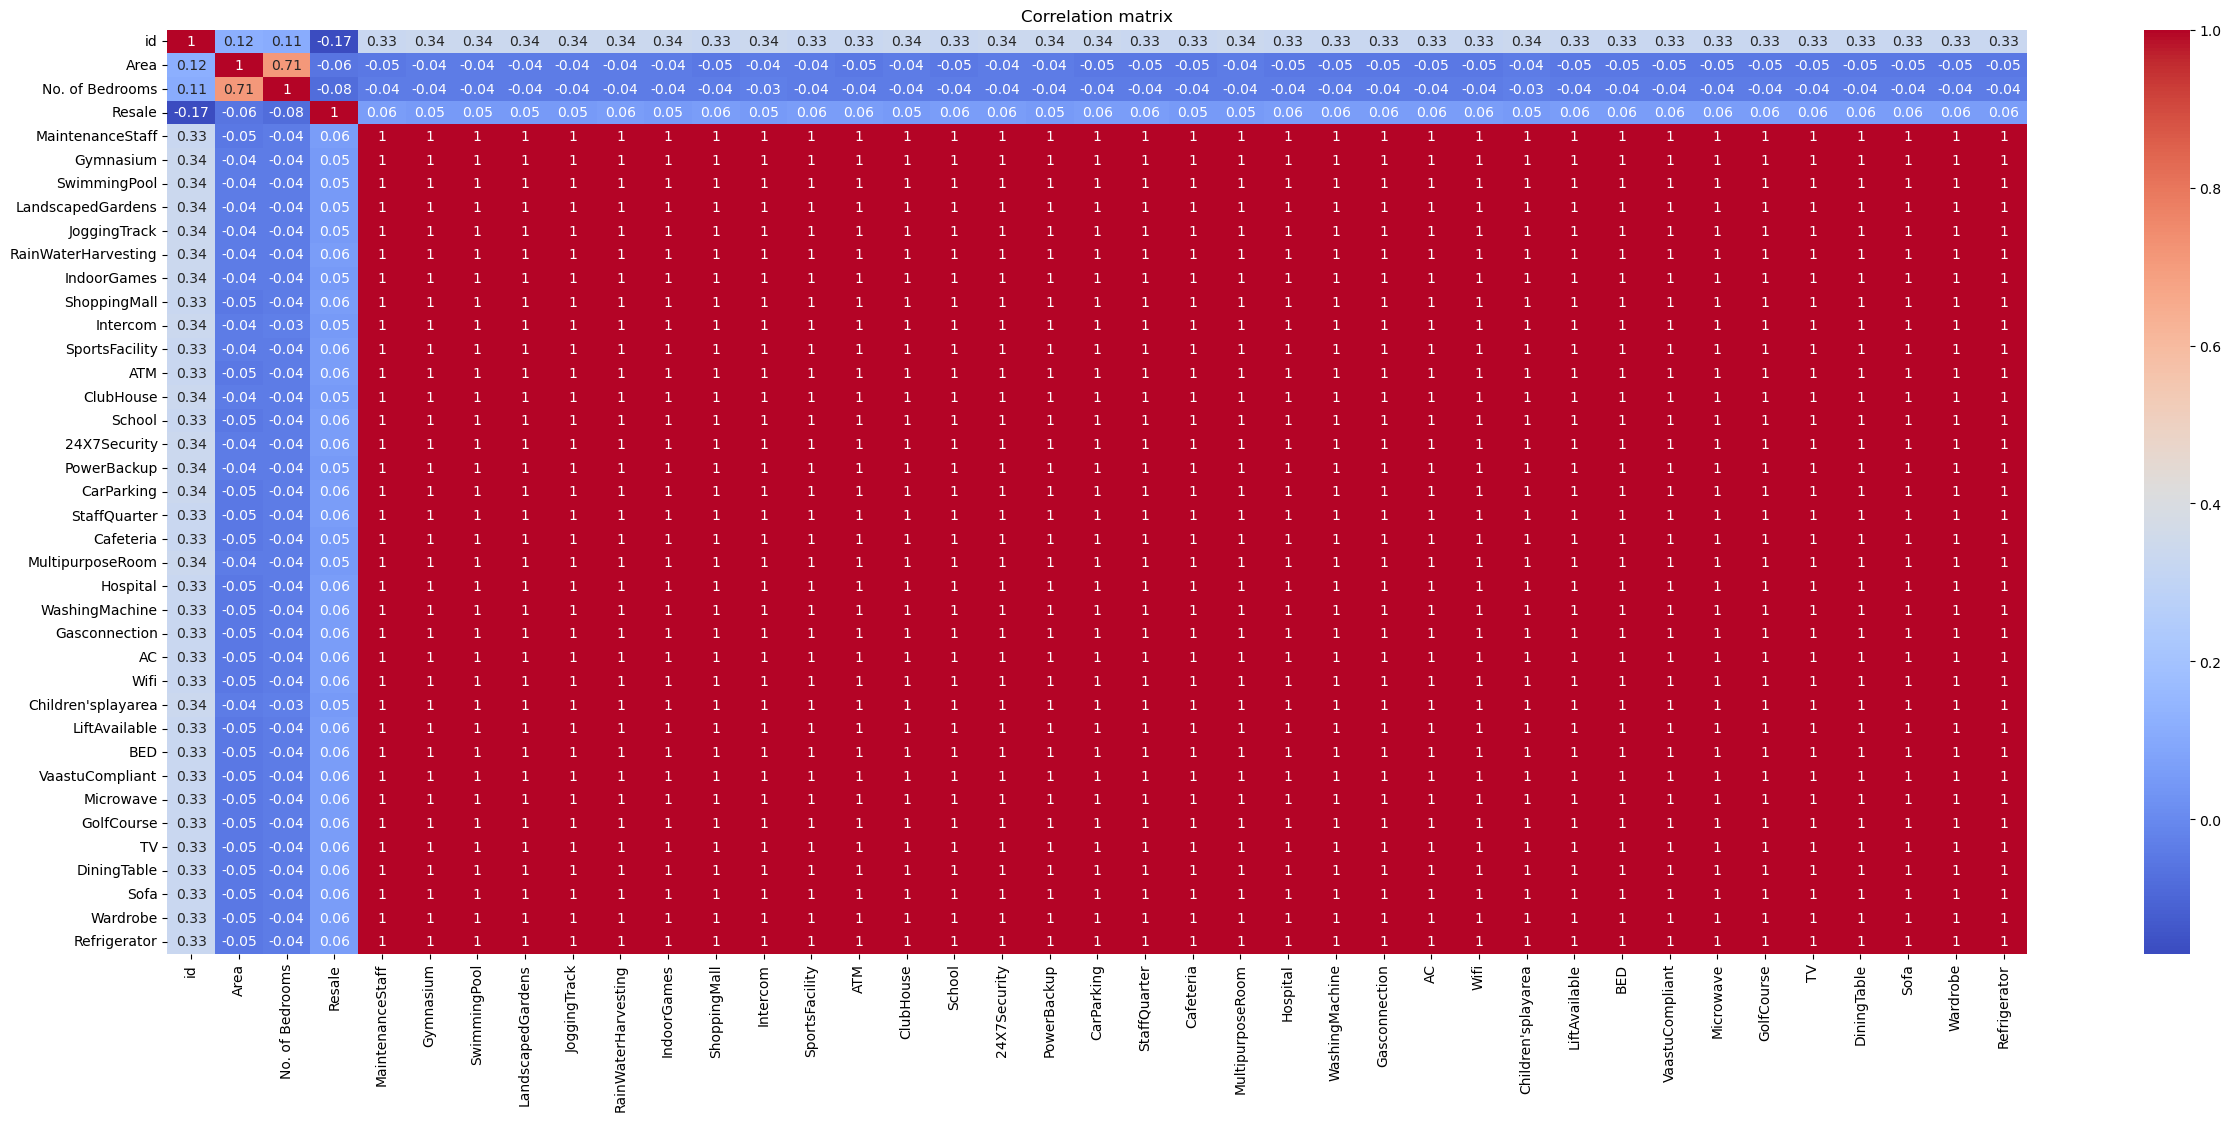

In [11]:
# correlation matrix for numerical columns
corr_matrix = train_df.select_dtypes(include=['int64', 'float64']).corr().round(2)
plt.figure(figsize=(30, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

In [12]:
# # drop columns with correlation 
# corr_matrix = train_df.select_dtypes(include=['int64', 'float64']).corr().abs()
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# to_drop = [column for column in upper.columns if any(upper[column] >= 0.8)]
# train_df.drop(to_drop, axis=1, inplace=True)
# test_df.drop(to_drop, axis=1, inplace=True)
# print(f'Dropped columns: {to_drop}')

In [13]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats
from sklearn.ensemble import RandomForestRegressor

train_df.drop('id', axis=1, inplace=True)
# One-Hot Encoding for Location
train_df = pd.get_dummies(train_df, columns=['Location'], drop_first=True)

# Interaction Features
train_df['Bedrooms_Area'] = train_df['No. of Bedrooms'] * train_df['Area']

X = train_df.drop('Price', axis=1)
y = train_df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Test with many models

In [14]:


# label_encoder = LabelEncoder()
# train_df['Location'] = label_encoder.fit_transform(train_df['Location'])
# train_df.drop('id', axis=1, inplace=True)


# X = train_df.drop('Price', axis=1)
# y = train_df['Price']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)


In [15]:
# best model for regression: RandomForestRegressor, GradientBoostingRegressor, XGBRegressor, LGBMRegressor, CatBoostRegressor, 
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

models = {
    'Linear Regression': LinearRegression(),
    'LGBM': LGBMRegressor(),
    'XGB': XGBRegressor(),
    'CatBoost': CatBoostRegressor()
}

for name, model in models.items():
    if name in ['CatBoost','LGBM']:
        model.set_params(verbose=0)
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    print(f'{name} RMSE: {root_mean_squared_error(y_test, y_pred)}')
    print(f'{name} R2 score: {r2_score(y_test, y_pred)}')



Linear Regression RMSE: 1694957360579044.5
Linear Regression R2 score: -6.873706499108453e+21
LGBM RMSE: 18602.477454066553
LGBM R2 score: 0.17202923329933728
XGB RMSE: 20839.30841936005
XGB R2 score: -0.039058582864205604
CatBoost RMSE: 19611.131540686212
CatBoost R2 score: 0.0798074029266137


In [16]:
param_lgbm = {
    'num_leaves': Integer(80, 150),
    'learning_rate': Real(0.01, 0.03),
    'n_estimators': Integer(300, 600),
    'subsample': Real(0.7, 1.0),
    'colsample_bytree': Real(0.2, 0.4),
    'min_split_gain': Real(0.0, 1.0),
    'min_child_samples': Integer(20, 50)
}

param_xgb = {
    'max_depth': Integer(1, 5),
    'learning_rate': Real(0.01, 0.1),
    'n_estimators': Integer(300, 600),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 0.8)
}

param_cat = {
    'depth': Integer(3, 7),
    'learning_rate': Real(0.01, 0.05),
    'iterations': Integer(600, 700),
    'bagging_temperature': Real(3.0, 7.0),
    'l2_leaf_reg': Real(3, 7)
}


np.int = int
opt_lgbm = BayesSearchCV(
    LGBMRegressor(verbose=0),
    param_lgbm,
    n_iter=32,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42,
)

opt_xgb = BayesSearchCV(
    XGBRegressor(),
    param_xgb,
    n_iter=32,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42,
)

opt_cat = BayesSearchCV(
    CatBoostRegressor(verbose=0),
    param_cat,
    n_iter=32,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42,
)


opt_models = {
    'LGBM': opt_lgbm,
    'CatBoost': opt_cat
}

for name, model in opt_models.items():
    # if name in ['CatBoost','LGBM']:
    #     model.set_params(verbose=0)
        
    model.fit(X_train_scaled, y_train)
    print(f'{name} RMSE: {model.best_score_}')
    for param, value in model.best_params_.items():
        print(f'{param}: {value}')
    print()

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\HP\anaconda3\envs\min_ds-env\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\HP\anaconda3\envs\min_ds-env\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\HP\anaconda3\envs\min_ds-env\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\HP\anaconda3\envs\min_ds-env\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\HP\anaconda3\envs\min_ds-env\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  

CatBoost RMSE: -22293.13106858248
bagging_temperature: 7.0
depth: 5
iterations: 700
l2_leaf_reg: 3.0
learning_rate: 0.01



In [17]:
X_combined = pd.concat([X_train, X_test])
y_combined = pd.concat([y_train, y_test])

X_combined = scaler.fit_transform(X_combined)

opt_lgbm.best_estimator_.fit(X_combined, y_combined)
# opt_xgb.best_estimator_.fit(X_combined, y_combined)
opt_cat.best_estimator_.fit(X_combined, y_combined)

rmse_test = {}
r2_test = {}
for name, model in opt_models.items():
    model.set_params(verbose=0)
    y_pred = model.best_estimator_.predict(X_test_scaled)
    rmse_test[name] = root_mean_squared_error(y_test, y_pred)
    r2_test[name] = r2_score(y_test, y_pred)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

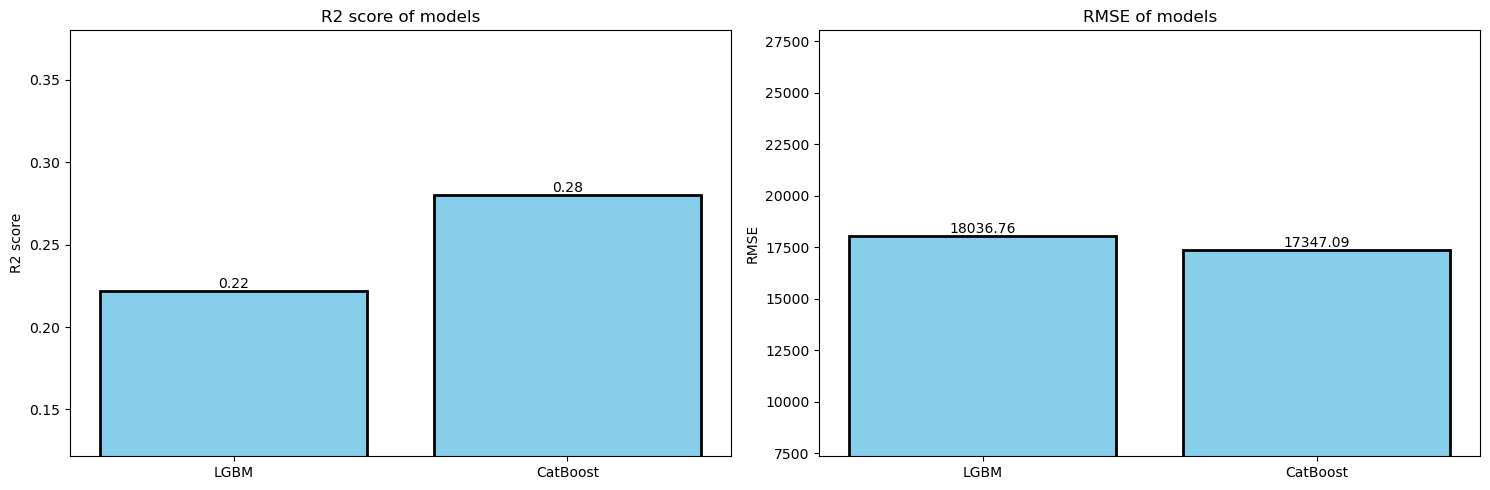

In [18]:
categories = list(r2_test.keys())
r2_values = list(r2_test.values())
rmse_test_values = list(rmse_test.values())

indices = np.arange(len(categories))

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

bars1 = ax[0].bar(indices, r2_values, color='skyblue', edgecolor='black', linewidth=2)
ax[0].set_ylabel('R2 score')
ax[0].set_xticks(indices)
ax[0].set_xticklabels(categories)
ax[0].set_title('R2 score of models')
ax[0].set_ylim(min(r2_values) - 0.1, max(r2_values) + 0.1)
ax[0].bar_label(bars1, fmt='%.2f')

bars2 = ax[1].bar(indices, rmse_test_values, color='skyblue', edgecolor='black', linewidth=2)
ax[1].set_ylabel('RMSE')
ax[1].set_xticks(indices)
ax[1].set_xticklabels(categories)
ax[1].set_title('RMSE of models')
ax[1].set_ylim(min(rmse_test_values) - 10000, max(rmse_test_values) + 10000)
ax[1].bar_label(bars2, fmt='%.2f')

plt.tight_layout()
plt.show()

In [19]:
best_model = min(rmse_test, key=rmse_test.get)

real_test_df = test_df.copy()
real_test_df.drop('id', axis=1, inplace=True)

real_test_df = pd.get_dummies(real_test_df, columns=['Location'], drop_first=True)

# Ensure that test data has the same dummy variables as training data
missing_cols = set(X_train.columns) - set(real_test_df.columns)
for c in missing_cols:
    real_test_df[c] = 0
real_test_df = real_test_df[X_train.columns]  # Reorder columns to match training data

real_test_df['Bedrooms_Area'] = real_test_df['No. of Bedrooms'] * real_test_df['Area']

X_real_test_scaled = scaler.transform(real_test_df)


y_real_test = opt_models[best_model].best_estimator_.predict(X_real_test_scaled)
# y_real_test = opt_cat.best_estimator_.predict(X_real_test_scaled)
y_real_test = y_real_test * 1000


submission = pd.DataFrame({'id': test_df['id'], 'Price': y_real_test})
submission.to_csv('submission.csv', index=False)

C:\Users\HP\AppData\Local\Temp\ipykernel_13508\2883655179.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  real_test_df[c] = 0
C:\Users\HP\AppData\Local\Temp\ipykernel_13508\2883655179.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  real_test_df[c] = 0
C:\Users\HP\AppData\Local\Temp\ipykernel_13508\2883655179.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1)